In [1]:
# Create a Simulate Environment

# Imports

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import os



%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from environment import LinearArray
from audio_datasets import YesNoDataset
from beamformer import DasBeamformer,MvdrBeamformer

## Linear Array

In [219]:
M = 9
L = 20000
d = 0.1
fs = 8000
lin_arr = LinearArray(M,L,d,fs)
print(lin_arr.__len__())

0


In [220]:
# Load signal

s1 = 1*torch.sin(2*np.pi *200* 1/fs*torch.arange(0,L))
s2 = 1*torch.sin(2*np.pi *500* 1/fs*torch.arange(0,L))
s3 = 3*torch.sin(2*np.pi *100* 1/fs*torch.arange(0,L))

sources = [s1,s2]
thetas = [30,0]

for i in range(len(sources)):
  lin_arr.add_signal(sources[i],theta=thetas[i])

target_i = 0

torch.Size([20000]) torch.Size([257, 79])
torch.Size([20000]) torch.Size([257, 79])


torch.Size([2, 9, 257])


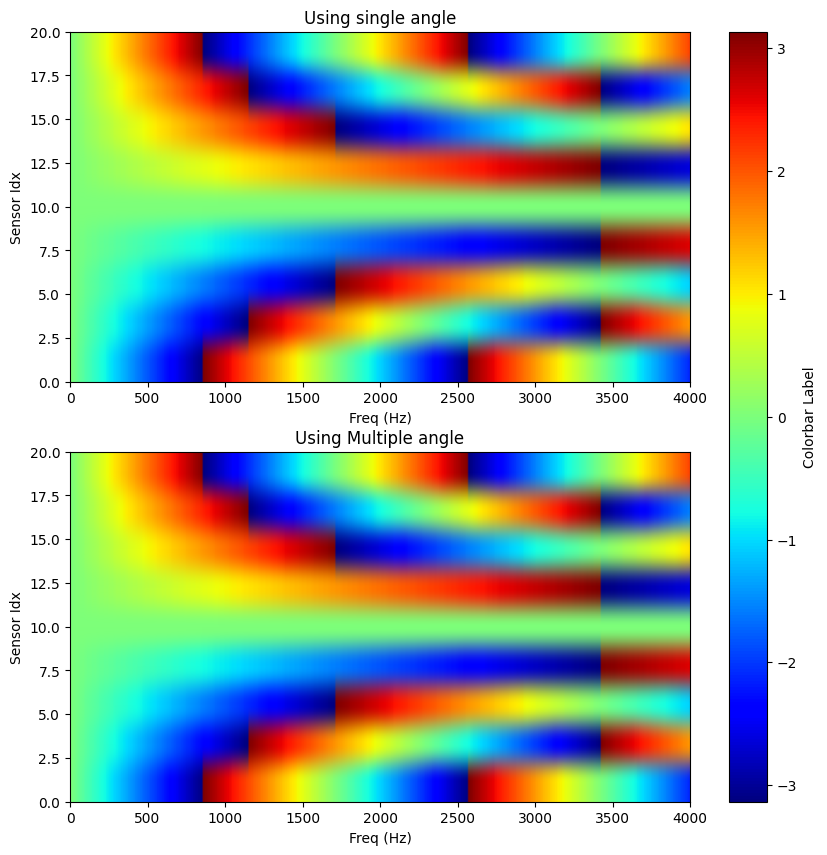

In [221]:
# Test S_Vec
s_vec = lin_arr.eval_svec(thetas[0])

# Test Multiple angles s_vec and index for 30 deg
s_vec_multi = lin_arr.eval_svec_multiangle(thetas)
print(s_vec_multi.shape)

# Plot if there is any discrepancy
f,ax = plt.subplots(2,1,figsize=(10,10))
im = ax[0].imshow(torch.angle(s_vec),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[0].set_title('Using single angle')
ax[1].imshow(torch.angle(s_vec_multi[0,:,:]),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[1].set_title('Using Multiple angle')
for i in range(len(ax)):
  ax[i].set_xlabel('Freq (Hz)')
  ax[i].set_ylabel('Sensor Idx')

# Add colorbar
cbar = f.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

In [222]:
# Sensor Reading Test
sensor_output = lin_arr.read_sensor()

print(sensor_output.shape) # M, L'

torch.Size([9, 19968])


(0.0, 600.0)

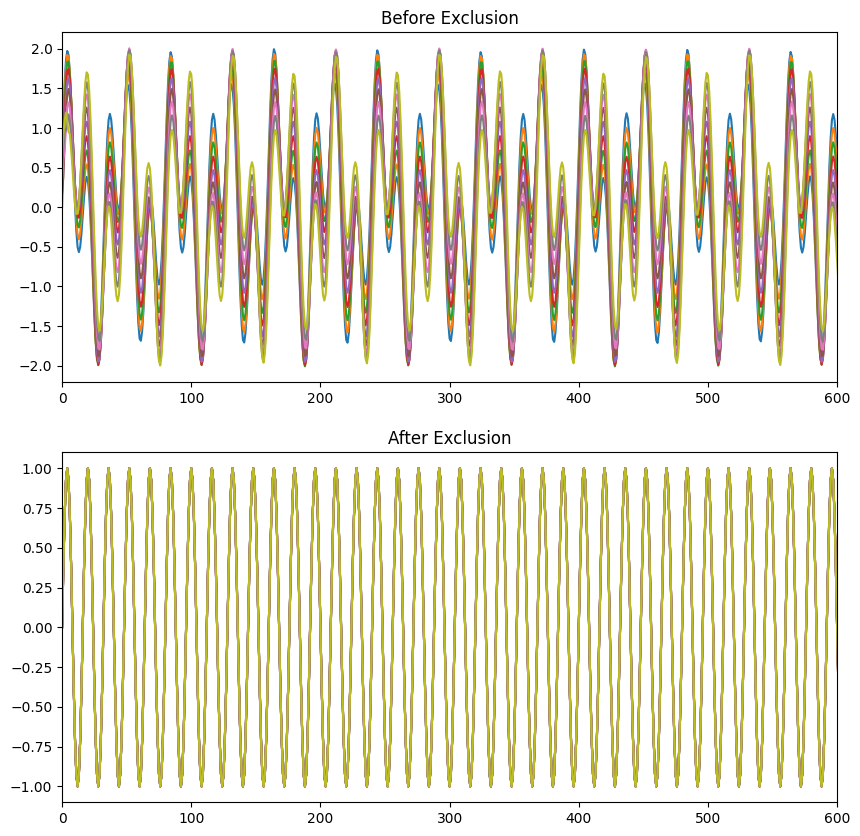

In [223]:
# Sensor Reading with Exclusion
sensor_output_minus = lin_arr.read_sensor(theta_exclude=thetas[target_i])

# plot the multi sensor data
fig,ax = plt.subplots(2,1,figsize=(10,10))

for m in range(M):
  x = sensor_output[m,:]
  ax[0].plot(x)

for m in range(M):
  x = sensor_output_minus[m,:]
  ax[1].plot(x)
ax[0].set_title('Before Exclusion')
ax[1].set_title('After Exclusion')
ax[0].set_xlim([0,600])
ax[1].set_xlim([0,600])

In [224]:
# Test DAS Beamformer
beamformer = DasBeamformer(lin_arr)

# DAS weight
w = beamformer.eval_weight(thetas[target_i])

# Apply the weight
Y = beamformer.apply_beamformer(thetas[target_i])


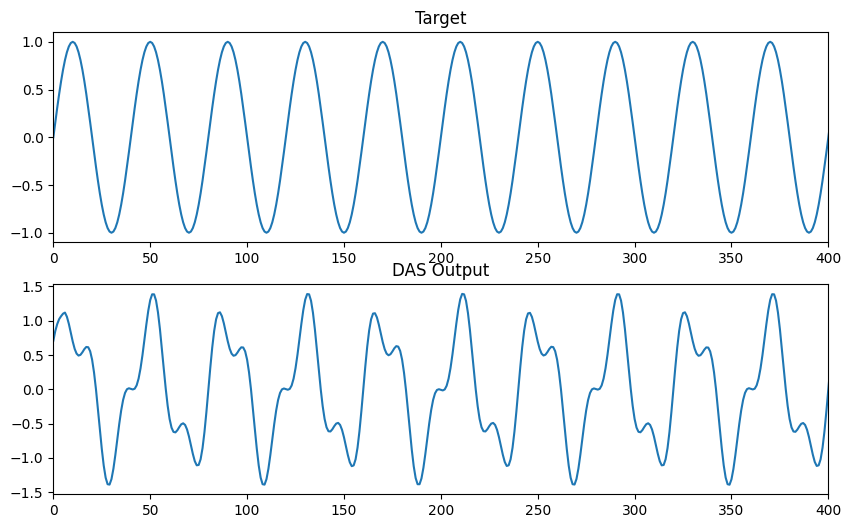

In [225]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
ax[1].plot(Y)
ax[1].set_title('DAS Output')

ax[0].plot(sources[target_i])
ax[0].set_title('Target')

for i in range(len(ax)):
  ax[i].set_xlim([0,400])

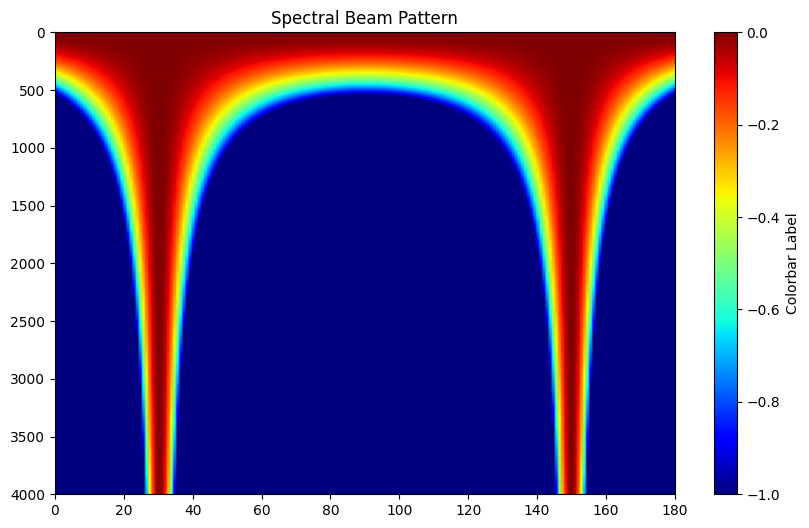

In [226]:
# Plot beam pattern
bp = beamformer.beam_pattern(target_theta=thetas[target_i],Ntheta=200)

fig,ax = plt.subplots(figsize=(10,6))
im = ax.imshow(bp,cmap='jet',aspect='auto',extent=[0,180,fs/2,0], clim=(-1,0))
ax.set_title('Spectral Beam Pattern')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

## MVDR

torch.Size([257, 200])


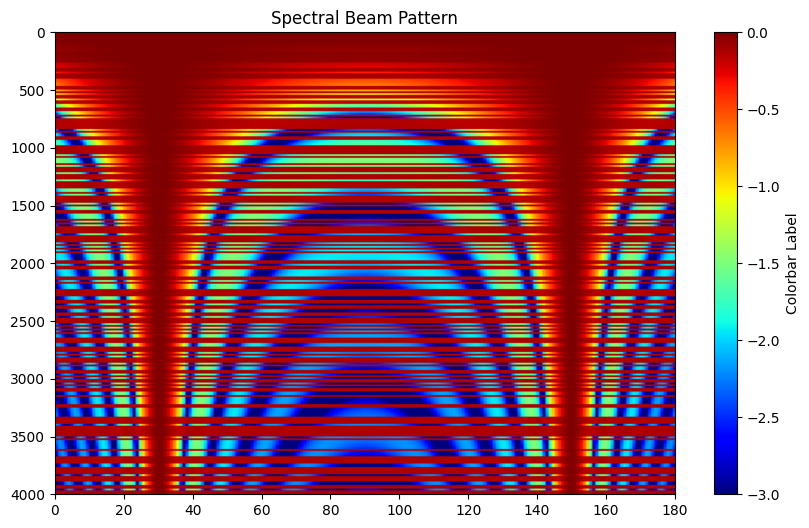

In [227]:
# Evaluate Beam pattern
# Plot beam pattern
beamformer = MvdrBeamformer(lin_arr)
bp = beamformer.beam_pattern(target_theta=thetas[target_i],Ntheta=200)
print(bp.shape)

fig,ax = plt.subplots(figsize=(10,6))
im = ax.imshow(bp,cmap='jet',aspect='auto',extent=[0,180,fs/2,0], clim=(-3,0))
ax.set_title('Spectral Beam Pattern')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

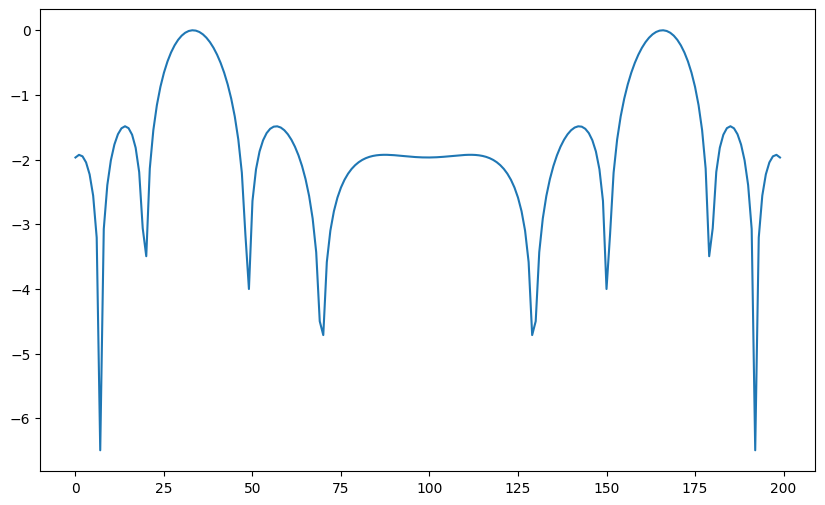

In [228]:
# Get a slice
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(bp[125,:])